<a href="https://colab.research.google.com/github/ritwiks9635/My_Neural_Network_Architecture/blob/main/Neural_Style_Transfer_with_AdaIN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Neural Style Transfer with AdaIN**

# Introduction

[Neural Style Transfer](https://www.tensorflow.org/tutorials/generative/style_transfer)
is the process of transferring the style of one image onto the content
of another. This was first introduced in the seminal paper
["A Neural Algorithm of Artistic Style"](https://arxiv.org/abs/1508.06576)
by Gatys et al. A major limitation of the technique proposed in this
work is in its runtime, as the algorithm uses a slow iterative
optimization process.

Follow-up papers that introduced
[Batch Normalization](https://arxiv.org/abs/1502.03167),
[Instance Normalization](https://arxiv.org/abs/1701.02096) and
[Conditional Instance Normalization](https://arxiv.org/abs/1610.07629)
allowed Style Transfer to be performed in new ways, no longer
requiring a slow iterative process.

Following these papers, the authors Xun Huang and Serge
Belongie propose
[Adaptive Instance Normalization](https://arxiv.org/abs/1703.06868) (AdaIN),
which allows arbitrary style transfer in real time.

In this example we implement Adaptive Instance Normalization
for Neural Style Transfer. We show in the below figure the output
of our AdaIN model trained for
only **30 epochs**.

![Style transfer sample gallery](https://i.imgur.com/zDjDuea.png)

You can also try out the model with your own images with this
[Hugging Face demo](https://huggingface.co/spaces/ariG23498/nst).

In [ ]:
!unzip /content/https:/www.kaggle.com/datasets/ikarus777/best-artworks-of-all-time/best-artworks-of-all-time.zip

In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras import layers

In [24]:
# Defining the global variables.
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
# Training for single epoch for time constraint.
# Please use atleast 30 epochs to see good results.
EPOCHS = 1
AUTOTUNE = tf.data.AUTOTUNE

## Style transfer sample gallery

For Neural Style Transfer we need style images and content images. In
this example we will use the
[Best Artworks of All Time](https://www.kaggle.com/ikarus777/best-artworks-of-all-time)
as our style dataset and
[Pascal VOC](https://www.tensorflow.org/datasets/catalog/voc)
as our content dataset.

This is a deviation from the original paper implementation by the
authors, where they use
[WIKI-Art](https://paperswithcode.com/dataset/wikiart) as style and
[MSCOCO](https://cocodataset.org/#home) as content datasets
respectively. We do this to create a minimal yet reproducible example.

## Downloading the dataset from Kaggle

The [Best Artworks of All Time](https://www.kaggle.com/ikarus777/best-artworks-of-all-time)
dataset is hosted on Kaggle and one can easily download it in Colab by
following these steps:

- Follow the instructions [here](https://github.com/Kaggle/kaggle-api)
in order to obtain your Kaggle API keys in case you don't have them.
- Use the following command to upload the Kaggle API keys.

```python
from google.colab import files
files.upload()
```

- Use the following commands to move the API keys to the proper
directory and download the dataset.

```shell
$ mkdir ~/.kaggle
$ cp kaggle.json ~/.kaggle/
$ chmod 600 ~/.kaggle/kaggle.json
$ kaggle datasets download ikarus777/best-artworks-of-all-time
$ unzip -qq best-artworks-of-all-time.zip
$ rm -rf images
$ mv resized artwork
$ rm best-artworks-of-all-time.zip artists.csv
```


## `tf.data` pipeline

In this section, we will build the `tf.data` pipeline for the project.
For the style dataset, we decode, convert and resize the images from
the folder. For the content images we are already presented with a
`tf.data` dataset as we use the `tfds` module.

After we have our style and content data pipeline ready, we zip the
two together to obtain the data pipeline that our model will consume.

In [25]:
def decode_and_resize(image_path):
    """Decodes and resizes an image from the image file path.

    Args:
        image_path: The image file path.

    Returns:
        A resized image.
    """
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, dtype="float32")
    image = tf.image.resize(image, IMAGE_SIZE)
    return image


def extract_image_from_voc(element):
    """Extracts image from the PascalVOC dataset.

    Args:
        element: A dictionary of data.

    Returns:
        A resized image.
    """
    image = element["image"]
    image = tf.image.convert_image_dtype(image, dtype="float32")
    image = tf.image.resize(image, IMAGE_SIZE)
    return image


# Get the image file paths for the style images.
style_images = os.listdir("/content/artwork/resized")
style_images = [os.path.join("/content/artwork/resized", path) for path in style_images]

# split the style images in train, val and test
total_style_images = len(style_images)
train_style = style_images[: int(0.8 * total_style_images)]
val_style = style_images[int(0.8 * total_style_images) : int(0.9 * total_style_images)]
test_style = style_images[int(0.9 * total_style_images) :]

# Build the style and content tf.data datasets.
train_style_ds = (
    tf.data.Dataset.from_tensor_slices(train_style)
    .map(decode_and_resize, num_parallel_calls=AUTOTUNE)
    .repeat()
)
train_content_ds = tfds.load("voc", split="train").map(extract_image_from_voc).repeat()

val_style_ds = (
    tf.data.Dataset.from_tensor_slices(val_style)
    .map(decode_and_resize, num_parallel_calls=AUTOTUNE)
    .repeat()
)
val_content_ds = (
    tfds.load("voc", split="validation").map(extract_image_from_voc).repeat()
)

test_style_ds = (
    tf.data.Dataset.from_tensor_slices(test_style)
    .map(decode_and_resize, num_parallel_calls=AUTOTUNE)
    .repeat()
)
test_content_ds = (
    tfds.load("voc", split="test")
    .map(extract_image_from_voc, num_parallel_calls=AUTOTUNE)
    .repeat()
)

# Zipping the style and content datasets.
train_ds = (
    tf.data.Dataset.zip((train_style_ds, train_content_ds))
    .shuffle(BATCH_SIZE * 2)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

val_ds = (
    tf.data.Dataset.zip((val_style_ds, val_content_ds))
    .shuffle(BATCH_SIZE * 2)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

test_ds = (
    tf.data.Dataset.zip((test_style_ds, test_content_ds))
    .shuffle(BATCH_SIZE * 2)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

## Visualizing the data

It is always better to visualize the data before training. To ensure
the correctness of our preprocessing pipeline, we visualize 10 samples
from our dataset.

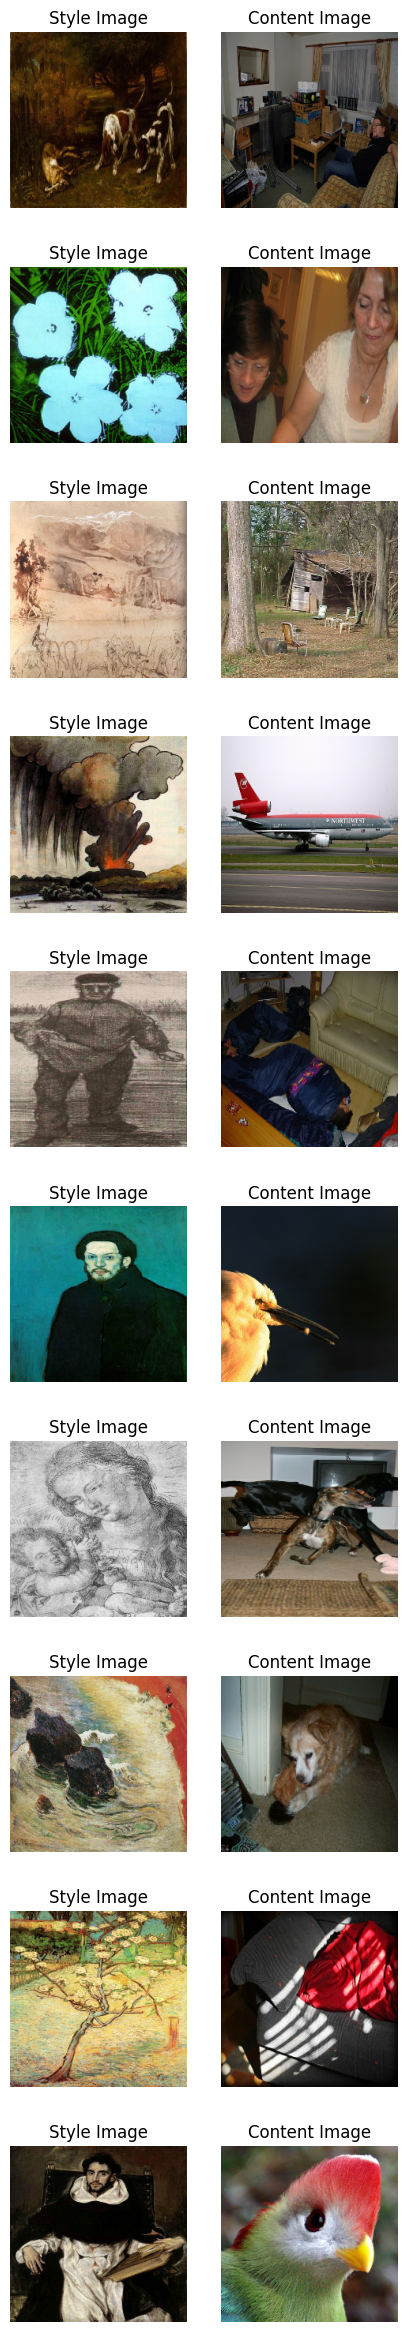

In [26]:
style, content = next(iter(train_ds))
fig, axes = plt.subplots(nrows=10, ncols=2, figsize=(5, 30))
[ax.axis("off") for ax in np.ravel(axes)]

for (axis, style_image, content_image) in zip(axes, style[0:10], content[0:10]):
    (ax_style, ax_content) = axis
    ax_style.imshow(style_image)
    ax_style.set_title("Style Image")

    ax_content.imshow(content_image)
    ax_content.set_title("Content Image")

## Architecture

The style transfer network takes a content image and a style image as
inputs and outputs the style transferred image. The authors of AdaIN
propose a simple encoder-decoder structure for achieving this.

![AdaIN architecture](https://i.imgur.com/JbIfoyE.png)

The content image (`C`) and the style image (`S`) are both fed to the
encoder networks. The output from these encoder networks (feature maps)
are then fed to the AdaIN layer. The AdaIN layer computes a combined
feature map. This feature map is then fed into a randomly initialized
decoder network that serves as the generator for the neural style
transferred image.

![AdaIn equation](https://i.imgur.com/hqhcBQS.png)

The style feature map (`fs`) and the content feature map (`fc`) are
fed to the AdaIN layer. This layer produced the combined feature map
`t`. The function `g` represents the decoder (generator) network.



### Encoder

The encoder is a part of the pretrained (pretrained on
[imagenet](https://www.image-net.org/)) VGG19 model. We slice the
model from the `block4-conv1` layer. The output layer is as suggested
by the authors in their paper.

In [27]:
def get_encoder():
    vgg19 = keras.applications.VGG19(
        include_top=False,
        weights="imagenet",
        input_shape=(*IMAGE_SIZE, 3),
    )
    vgg19.trainable = False
    mini_vgg19 = keras.Model(vgg19.input, vgg19.get_layer("block4_conv1").output)

    inputs = layers.Input([*IMAGE_SIZE, 3])
    mini_vgg19_out = mini_vgg19(inputs)
    return keras.Model(inputs, mini_vgg19_out, name="mini_vgg19")

### Adaptive Instance Normalization

The AdaIN layer takes in the features
of the content and style image. The layer can be defined via the
following equation:

![AdaIn formula](https://i.imgur.com/tWq3VKP.png)

where `sigma` is the standard deviation and `mu` is the mean for the
concerned variable. In the above equation the mean and variance of the
content feature map `fc` is aligned with the mean and variance of the
style feature maps `fs`.

It is important to note that the AdaIN layer proposed by the authors
uses no other parameters apart from mean and variance. The layer also
does not have any trainable parameters. This is why we use a
*Python function* instead of using a *Keras layer*. The function takes
style and content feature maps, computes the mean and standard deviation
of the images and returns the adaptive instance normalized feature map.

In [28]:
def get_mean_std(x, epsilon=1e-5):
    axes = [1, 2]

    # Compute the mean and standard deviation of a tensor.
    mean, variance = tf.nn.moments(x, axes=axes, keepdims=True)
    standard_deviation = tf.sqrt(variance + epsilon)
    return mean, standard_deviation


def ada_in(style, content):
    """Computes the AdaIn feature map.

    Args:
        style: The style feature map.
        content: The content feature map.

    Returns:
        The AdaIN feature map.
    """
    content_mean, content_std = get_mean_std(content)
    style_mean, style_std = get_mean_std(style)
    t = style_std * (content - content_mean) / content_std + style_mean
    return t

### Decoder

The authors specify that the decoder network must mirror the encoder
network.  We have symmetrically inverted the encoder to build our
decoder. We have used `UpSampling2D` layers to increase the spatial
resolution of the feature maps.

Note that the authors warn against using any normalization layer
in the decoder network, and do indeed go on to show that including
batch normalization or instance normalization hurts the performance
of the overall network.

This is the only portion of the entire architecture that is trainable.

In [29]:
def get_decoder():
    config = {"kernel_size": 3, "strides": 1, "padding": "same", "activation": "relu"}
    decoder = keras.Sequential(
        [
            layers.InputLayer((None, None, 512)),
            layers.Conv2D(filters=512, **config),
            layers.UpSampling2D(),
            layers.Conv2D(filters=256, **config),
            layers.Conv2D(filters=256, **config),
            layers.Conv2D(filters=256, **config),
            layers.Conv2D(filters=256, **config),
            layers.UpSampling2D(),
            layers.Conv2D(filters=128, **config),
            layers.Conv2D(filters=128, **config),
            layers.UpSampling2D(),
            layers.Conv2D(filters=64, **config),
            layers.Conv2D(
                filters=3,
                kernel_size=3,
                strides=1,
                padding="same",
                activation="sigmoid",
            ),
        ]
    )
    return decoder

### Loss functions

Here we build the loss functions for the neural style transfer model.
The authors propose to use a pretrained VGG-19 to compute the loss
function of the network. It is important to keep in mind that this
will be used for training only the decoder network. The total
loss (`Lt`) is a weighted combination of content loss (`Lc`) and style
loss (`Ls`). The `lambda` term is used to vary the amount of style
transferred.

![The total loss](https://i.imgur.com/Q5y1jUM.png)

### Content Loss

This is the Euclidean distance between the content image features
and the features of the neural style transferred image.

![The content loss](https://i.imgur.com/dZ0uD0N.png)

Here the authors propose to use the output from the AdaIn layer `t` as
the content target rather than using features of the original image as
target. This is done to speed up convergence.

### Style Loss

Rather than using the more commonly used
[Gram Matrix](https://mathworld.wolfram.com/GramMatrix.html),
the authors propose to compute the difference between the statistical features
(mean and variance) which makes it conceptually cleaner. This can be
easily visualized via the following equation:

![The style loss](https://i.imgur.com/Ctclhn3.png)

where `theta` denotes the layers in VGG-19 used to compute the loss.
In this case this corresponds to:

- `block1_conv1`
- `block1_conv2`
- `block1_conv3`
- `block1_conv4`

In [30]:
def get_loss_net():
    vgg19 = keras.applications.VGG19(
        include_top=False, weights="imagenet", input_shape=(*IMAGE_SIZE, 3)
    )
    vgg19.trainable = False
    layer_names = ["block1_conv1", "block2_conv1", "block3_conv1", "block4_conv1"]
    outputs = [vgg19.get_layer(name).output for name in layer_names]
    mini_vgg19 = keras.Model(vgg19.input, outputs)

    inputs = layers.Input([*IMAGE_SIZE, 3])
    mini_vgg19_out = mini_vgg19(inputs)
    return keras.Model(inputs, mini_vgg19_out, name="loss_net")

## Neural Style Transfer

This is the trainer module. We wrap the encoder and decoder inside
a `tf.keras.Model` subclass. This allows us to customize what happens
in the `model.fit()` loop.

In [31]:
class NeuralStyleTransfer(tf.keras.Model):
    def __init__(self, encoder, decoder, loss_net, style_weight, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.loss_net = loss_net
        self.style_weight = style_weight

    def compile(self, optimizer, loss_fn):
        super().compile()
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.style_loss_tracker = keras.metrics.Mean(name="style_loss")
        self.content_loss_tracker = keras.metrics.Mean(name="content_loss")
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")

    def train_step(self, inputs):
        style, content = inputs

        # Initialize the content and style loss.
        loss_content = 0.0
        loss_style = 0.0

        with tf.GradientTape() as tape:
            # Encode the style and content image.
            style_encoded = self.encoder(style)
            content_encoded = self.encoder(content)

            # Compute the AdaIN target feature maps.
            t = ada_in(style=style_encoded, content=content_encoded)

            # Generate the neural style transferred image.
            reconstructed_image = self.decoder(t)

            # Compute the losses.
            reconstructed_vgg_features = self.loss_net(reconstructed_image)
            style_vgg_features = self.loss_net(style)
            loss_content = self.loss_fn(t, reconstructed_vgg_features[-1])
            for inp, out in zip(style_vgg_features, reconstructed_vgg_features):
                mean_inp, std_inp = get_mean_std(inp)
                mean_out, std_out = get_mean_std(out)
                loss_style += self.loss_fn(mean_inp, mean_out) + self.loss_fn(
                    std_inp, std_out
                )
            loss_style = self.style_weight * loss_style
            total_loss = loss_content + loss_style

        # Compute gradients and optimize the decoder.
        trainable_vars = self.decoder.trainable_variables
        gradients = tape.gradient(total_loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the trackers.
        self.style_loss_tracker.update_state(loss_style)
        self.content_loss_tracker.update_state(loss_content)
        self.total_loss_tracker.update_state(total_loss)
        return {
            "style_loss": self.style_loss_tracker.result(),
            "content_loss": self.content_loss_tracker.result(),
            "total_loss": self.total_loss_tracker.result(),
        }

    def test_step(self, inputs):
        style, content = inputs

        # Initialize the content and style loss.
        loss_content = 0.0
        loss_style = 0.0

        # Encode the style and content image.
        style_encoded = self.encoder(style)
        content_encoded = self.encoder(content)

        # Compute the AdaIN target feature maps.
        t = ada_in(style=style_encoded, content=content_encoded)

        # Generate the neural style transferred image.
        reconstructed_image = self.decoder(t)

        # Compute the losses.
        recons_vgg_features = self.loss_net(reconstructed_image)
        style_vgg_features = self.loss_net(style)
        loss_content = self.loss_fn(t, recons_vgg_features[-1])
        for inp, out in zip(style_vgg_features, recons_vgg_features):
            mean_inp, std_inp = get_mean_std(inp)
            mean_out, std_out = get_mean_std(out)
            loss_style += self.loss_fn(mean_inp, mean_out) + self.loss_fn(
                std_inp, std_out
            )
        loss_style = self.style_weight * loss_style
        total_loss = loss_content + loss_style

        # Update the trackers.
        self.style_loss_tracker.update_state(loss_style)
        self.content_loss_tracker.update_state(loss_content)
        self.total_loss_tracker.update_state(total_loss)
        return {
            "style_loss": self.style_loss_tracker.result(),
            "content_loss": self.content_loss_tracker.result(),
            "total_loss": self.total_loss_tracker.result(),
        }

    @property
    def metrics(self):
        return [
            self.style_loss_tracker,
            self.content_loss_tracker,
            self.total_loss_tracker,
        ]

## Train Monitor callback

This callback is used to visualize the style transfer output of
the model at the end of each epoch. The objective of style transfer cannot be
quantified properly, and is to be subjectively evaluated by an audience.
For this reason, visualization is a key aspect of evaluating the model.

In [32]:
test_style, test_content = next(iter(test_ds))


class TrainMonitor(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Encode the style and content image.
        test_style_encoded = self.model.encoder(test_style)
        test_content_encoded = self.model.encoder(test_content)

        # Compute the AdaIN features.
        test_t = ada_in(style=test_style_encoded, content=test_content_encoded)
        test_reconstructed_image = self.model.decoder(test_t)

        # Plot the Style, Content and the NST image.
        fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
        ax[0].imshow(tf.keras.utils.array_to_img(test_style[0]))
        ax[0].set_title(f"Style: {epoch:03d}")

        ax[1].imshow(tf.keras.utils.array_to_img(test_content[0]))
        ax[1].set_title(f"Content: {epoch:03d}")

        ax[2].imshow(
            tf.keras.utils.array_to_img(test_reconstructed_image[0])
        )
        ax[2].set_title(f"NST: {epoch:03d}")

        plt.show()
        plt.close()

## Train the model

In this section, we define the optimizer, the loss function, and the
trainer module. We compile the trainer module with the optimizer and
the loss function and then train it.

*Note*: We train the model for a single epoch for time constraints,
but we will need to train is for atleast 30 epochs to see good results.

50/50 [==============================] - ETA: 0s - style_loss: 181.8693 - content_loss: 136.8377 - total_loss: 318.7069

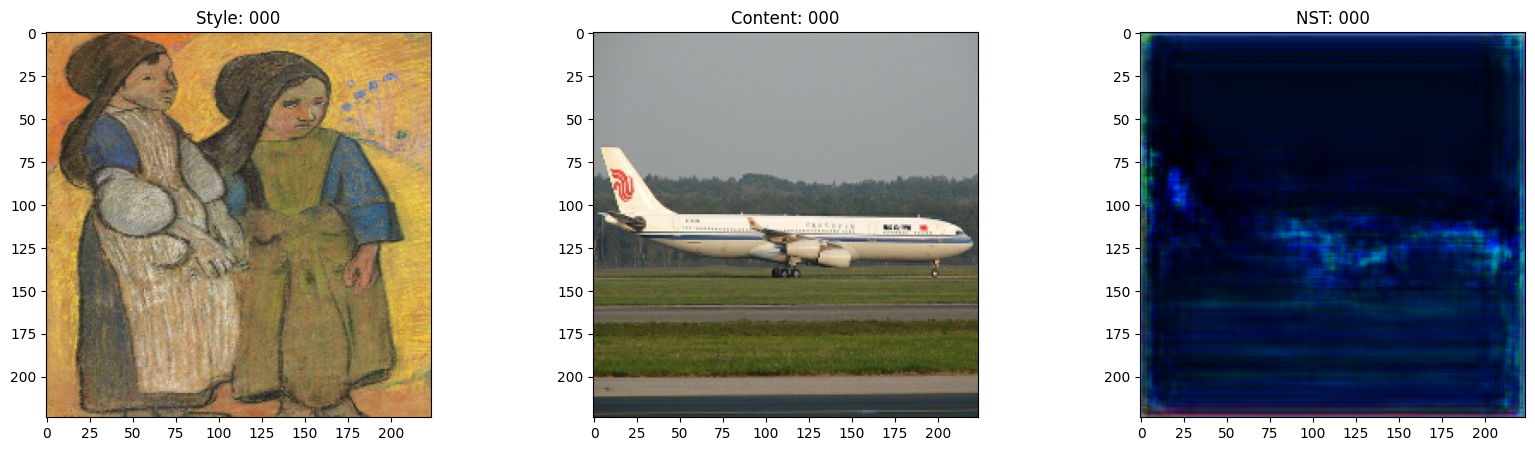

50/50 [==============================] - 170s 2s/step - style_loss: 181.8693 - content_loss: 136.8377 - total_loss: 318.7069 - val_style_loss: 155.3188 - val_content_loss: 129.5362 - val_total_loss: 284.8549


In [33]:
optimizer = keras.optimizers.Adam(learning_rate=1e-5)
loss_fn = keras.losses.MeanSquaredError()

encoder = get_encoder()
loss_net = get_loss_net()
decoder = get_decoder()

model = NeuralStyleTransfer(
    encoder=encoder, decoder=decoder, loss_net=loss_net, style_weight=4.0
)

model.compile(optimizer=optimizer, loss_fn=loss_fn)

history = model.fit(
    train_ds,
    epochs=EPOCHS,
    steps_per_epoch=50,
    validation_data=val_ds,
    validation_steps=50,
    callbacks=[TrainMonitor()],
)

## Inference

After we train the model, we now need to run inference with it. We will
pass arbitrary content and style images from the test dataset and take a look at
the output images.

*NOTE*: To try out the model on your own images, you can use this
[Hugging Face demo](https://huggingface.co/spaces/ariG23498/nst).

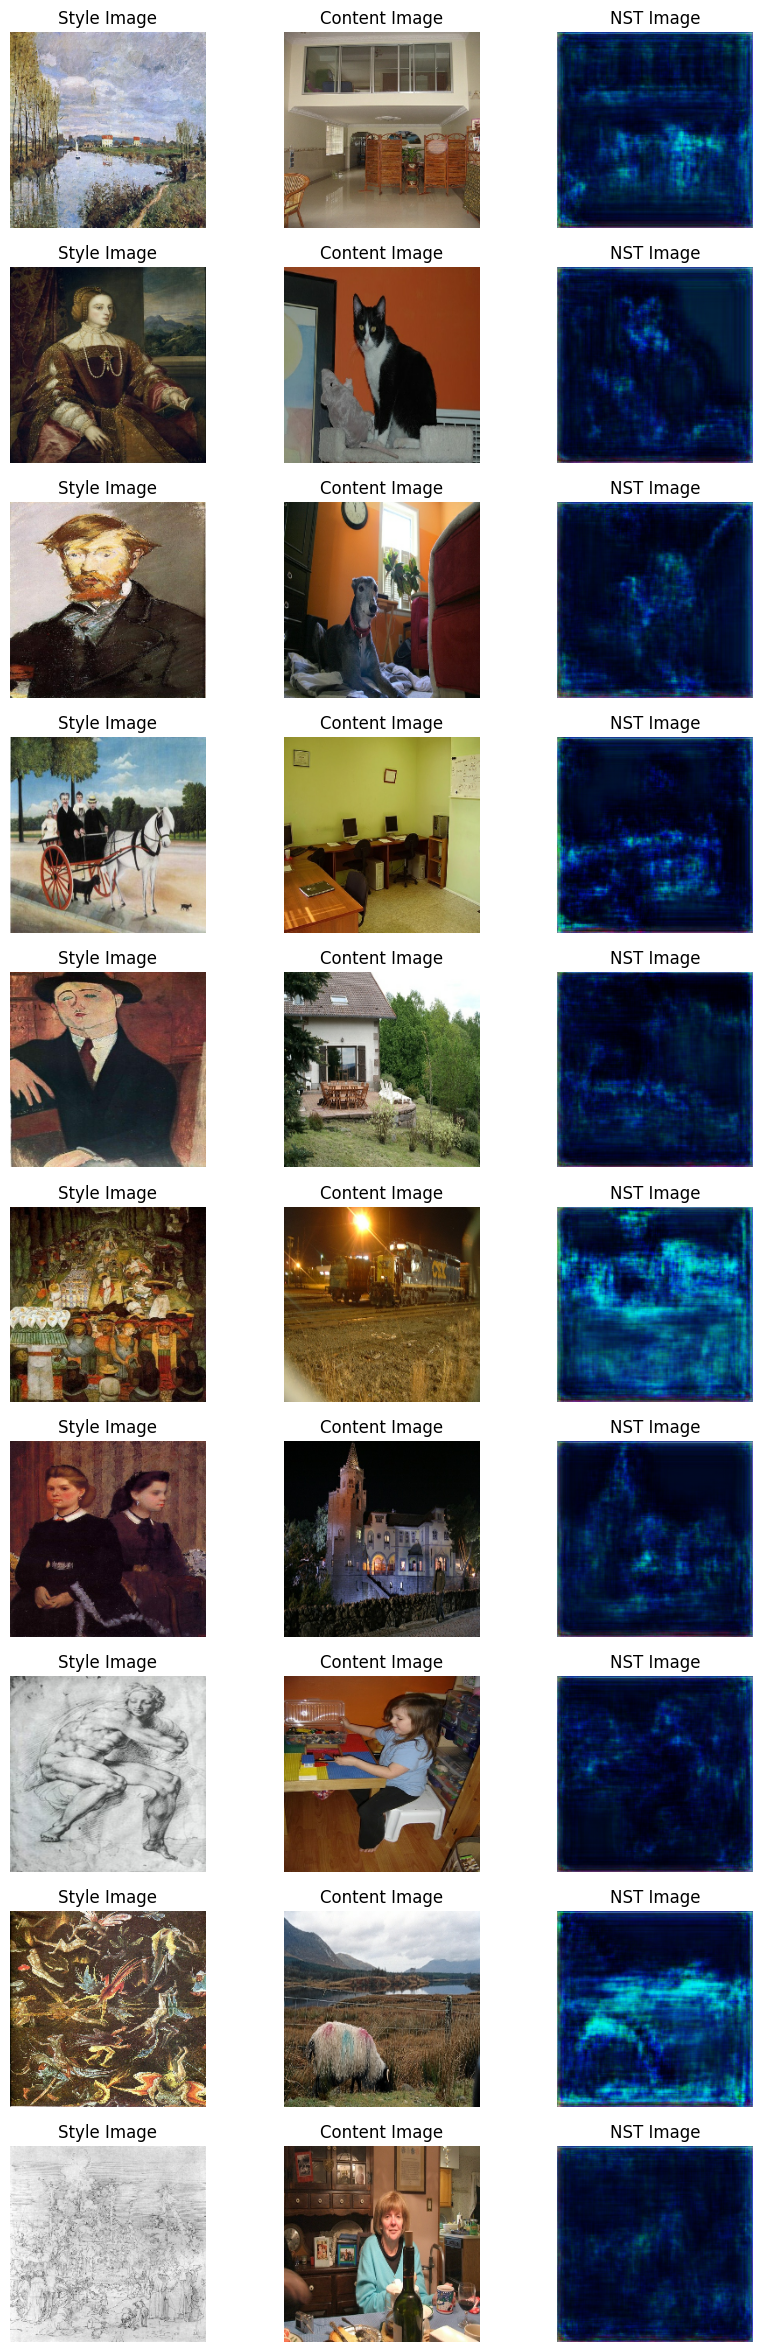

In [34]:
for style, content in test_ds.take(1):
    style_encoded = model.encoder(style)
    content_encoded = model.encoder(content)
    t = ada_in(style=style_encoded, content=content_encoded)
    reconstructed_image = model.decoder(t)
    fig, axes = plt.subplots(nrows=10, ncols=3, figsize=(10, 30))
    [ax.axis("off") for ax in np.ravel(axes)]

    for axis, style_image, content_image, reconstructed_image in zip(
        axes, style[0:10], content[0:10], reconstructed_image[0:10]
    ):
        (ax_style, ax_content, ax_reconstructed) = axis
        ax_style.imshow(style_image)
        ax_style.set_title("Style Image")
        ax_content.imshow(content_image)
        ax_content.set_title("Content Image")
        ax_reconstructed.imshow(reconstructed_image)
        ax_reconstructed.set_title("NST Image")

## Conclusion

Adaptive Instance Normalization allows arbitrary style transfer in
real time. It is also important to note that the novel proposition of
the authors is to achieve this only by aligning the statistical
features (mean and standard deviation) of the style and the content
images.

*Note*: AdaIN also serves as the base for
[Style-GANs](https://arxiv.org/abs/1812.04948).